# Projeto 1 - Ciência dos Dados

Nome: Beatriz Bobrow Bozzo

Nome: Rodrigo Nigri Griner

Nome: Thais Sztamfater Groberman

**Atenção:** Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

**Em `filename`, coloque o nome do seu arquivo de dados!**

In [2]:
import os

filename = 'Nike.xlsx'
if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo para prosseguir com a prova!')
else:
    print(f'Não encontrei o arquivo {filename} aqui no diretório {os.getcwd()}, será que você não baixou o arquivo?')

Encontrei o arquivo Nike.xlsx, tudo certo para prosseguir com a prova!


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Classificação
0,peguei o busao logo com um mlk mo gato trajadi...,Elogio
1,@fabiotalhari @zikab38 é o fotógrafo do marcel...,Indiferente
2,pelo menos meu nike air force 1 branco tam 41 ...,Elogio
3,@heinekenbr @backtothewar @vicebrasil @nike es...,Crítica
4,"queria outro tênis da nike, mas aq em jequié n...",Crítica


In [4]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Classificação
0,@vicebrasil @nike @heinekenbr cortem seus patr...,Crítica
1,várias camisas de time por 100 conto no site d...,Elogio
2,@heinekenbr @backtothewar @vicebrasil @nike le...,Indiferente
3,@millenaolv com ele te sequestrando,Indiferente
4,vou essa semana no shopping pegar meu tênis da...,Elogio


___
## Classificador automático de sentimento


Consideramos como elogios os tweets que comentam pontos positivos da marca, assim como a classificação de crítica classifica os tweets com comentários negativos sobre a marca. Por fim, os classificados com indiferente são aqueles que não fazem críticas, nem elogios apenas comentários citando a Nike.

___
# Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

Inicialmente, vamos definir uma função que irá limpar os tweets para que a análise não seja comprometida.

In [33]:
import re

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[!-.:?;&…]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    user = r'@\w+'
    pattern_2 = re.compile(user)
    text_subbed= re.sub( pattern_2,'', text)
    
    
    return text_subbed

Vamos separar cada tweet da sessão de Treinamento devido a sua classificação adicionando uma nova tabela.

In [34]:
elogio = train['Classificação'] == 'Elogio'
critica = train['Classificação'] == 'Crítica'
indiferente = train['Classificação'] == 'Indiferente'

train_elogio = train.loc[elogio, :]
train_critica = train.loc[critica,:]
train_indiferente = train.loc[indiferente, :]

In [35]:
prob_geral= train['Classificação'].value_counts(True)
prob_geral

Indiferente    0.374
Elogio         0.364
Crítica        0.262
Name: Classificação, dtype: float64

In [36]:
# Vamos adicionar as probabilidades de ser elogio, crítica ou indiferente em diferentes variáveis!
prob_indiferente = prob_geral[0]
prob_elogio = prob_geral[1]
prob_critica = prob_geral[2]

# Lista com as probabilidades
lista_prob_geral = [prob_elogio, prob_indiferente, prob_critica]

print('A probabilidade de ser indiferente é: {0}!'.format(prob_indiferente))
print('A probabilidade de ser elogio é: {0}!'.format(prob_elogio))
print('A probabilidade de ser crítica é: {0}!'.format(prob_critica))

A probabilidade de ser indiferente é: 0.374!
A probabilidade de ser elogio é: 0.364!
A probabilidade de ser crítica é: 0.262!


___
## Tabela de frequências: Indiferente

Para iniciar, vamos adicionar numa string todas as palavras dos tweets classificados como indiferente:

In [37]:
string_indiferente = ''
for i in train_indiferente['Treinamento']:
    string_indiferente += i
    
# Limpando as strings com a função clean up e separando-as em uma lista para facilitar a contagem!
cleanup_string_indiferente = cleanup(string_indiferente.lower())
todas_palavras_indiferente = cleanup_string_indiferente.split()

# Observando essa string com todas as palavras
todas_palavras_indiferente[0:20]

['é',
 'o',
 'fotógrafo',
 'do',
 'marcelo',
 'd2',
 'fábio,',
 'faz',
 'trabalhos',
 'tbm',
 'para',
 'heineken',
 'e',
 'nike...',
 'n',
 'sabem',
 'nem',
 'que',
 'existem',
 'mts']

Agora, vamos construir a tabela de frequência absoluta para as palavras de cada tweet classificado. Primeiramente vamos converter os tweets (strings contendo o texto completo) em objetos do tipo `pd.Series`, nos quais cada elemento é uma palavra.

In [38]:
serie_indiferente = pd.Series(todas_palavras_indiferente)
serie_indiferente

0                   é
1                   o
2           fotógrafo
3                  do
4             marcelo
            ...      
2826     atitudes....
2827                o
2828    comportamento
2829            nunca
2830       mente!!!!🤐
Length: 2831, dtype: object

In [39]:
# Frequência absoluta das palavras indiferentes
freq_abs_indiferente = serie_indiferente.value_counts()
freq_abs_indiferente

de            83
nike          77
da            71
e             65
que           63
              ..
enquanto       1
sabem          1
tb,            1
pega           1
bonitinho,     1
Length: 1318, dtype: int64

## Tabela de frequências: Elogio

Para iniciar, vamos adicionar numa string todas as palavras dos tweets classificados como elogio:

In [40]:
string_elogio = ''
for i in train_elogio['Treinamento']:
    string_elogio += i

# Limpando as strings com a função clean up e separando-as em uma lista para facilitar a contagem!
cleanup_string_elogio = cleanup(string_elogio.lower())
todas_palavras_elogio = cleanup_string_elogio.split()


# Observando essa string com todas as palavras
todas_palavras_elogio[0:20]

['peguei',
 'o',
 'busao',
 'logo',
 'com',
 'um',
 'mlk',
 'mo',
 'gato',
 'trajadinho',
 'de',
 'um',
 'conjunto',
 'da',
 'nike',
 'vintage',
 'pqppelo',
 'menos',
 'meu',
 'nike']

Agora, vamos construir a tabela de frequência absoluta para as palavras de cada tweet classificado. Primeiramente vamos converter os tweets (strings contendo o texto completo) em objetos do tipo `pd.Series`, nos quais cada elemento é uma palavra.

In [41]:
serie_elogio = pd.Series(todas_palavras_elogio)
serie_elogio

0         peguei
1              o
2          busao
3           logo
4            com
          ...   
2194         que
2195       vende
2196         uns
2197        nike
2198    nervoso?
Length: 2199, dtype: object

In [42]:
# Frequência absoluta das palavras elogio
freq_abs_elogio = serie_elogio.value_counts()
freq_abs_elogio

nike                         137
da                           105
de                            57
é                             43
que                           41
                            ... 
beltrão                        1
https://t.co/9d9h5ltymzrt      1
41                             1
sistema                        1
adidasqueria                   1
Length: 905, dtype: int64

## Tabela de frequências: Crítica

Para iniciar, vamos adicionar numa string todas as palavras dos tweets classificados como elogio:

In [43]:
string_critica = ''
for i in train_critica['Treinamento']:
    string_critica += i

# Limpando as strings com a função clean up e separando-as em uma lista para facilitar a contagem!
cleanup_string_critica = cleanup(string_critica.lower())
todas_palavras_critica = cleanup_string_critica.split()

# Observando essa string com todas as palavras
todas_palavras_elogio[0:20]

['peguei',
 'o',
 'busao',
 'logo',
 'com',
 'um',
 'mlk',
 'mo',
 'gato',
 'trajadinho',
 'de',
 'um',
 'conjunto',
 'da',
 'nike',
 'vintage',
 'pqppelo',
 'menos',
 'meu',
 'nike']

Agora, vamos construir a tabela de frequência absoluta para as palavras de cada tweet classificado. Primeiramente vamos converter os tweets (strings contendo o texto completo) em objetos do tipo `pd.Series`, nos quais cada elemento é uma palavra.

In [44]:
serie_critica = pd.Series(todas_palavras_critica)
serie_critica

0       escrever
1              é
2           bom.
3            mas
4       atitudes
          ...   
1819        amo,
1820         mas
1821        este
1822         não
1823          dá
Length: 1824, dtype: object

In [45]:
# Frequência absoluta das palavras críticas
freq_abs_critica = serie_critica.value_counts()
freq_abs_critica

nike                       90
da                         61
de                         50
que                        46
e                          40
                           ..
paguei                      1
fizesse                     1
https://t.co/ltfo0emhvz     1
assinou                     1
kk                          1
Length: 740, dtype: int64

Queremos descobrir a probabilidade de uma palavra ocorrer nos tweets. Para isso, vamos assumir que a probabilidade de uma palavra ocorrer em um tweet é independente da probabilidade de qualquer outra palavra. Assim, assumindo independência, **a probabilidade do tweet é igual ao produto das probabilidades de cada palavra individualmente**.

## Tabela de frequências: Tweets
Vamos observar as frequências das palavras juntando todos os tweets!

In [46]:
string_tweets = ''
for i in train['Treinamento']:
    string_tweets += i

# Limpando as strings com a função clean up e separando-as em uma lista para facilitar a contagem!
cleanup_string_tweets = cleanup(string_tweets.lower())
todas_palavras_tweets = cleanup_string_tweets.split()

# Observando essa string com todas as palavras
todas_palavras_tweets[0:20]

['peguei',
 'o',
 'busao',
 'logo',
 'com',
 'um',
 'mlk',
 'mo',
 'gato',
 'trajadinho',
 'de',
 'um',
 'conjunto',
 'da',
 'nike',
 'vintage',
 'pqp',
 'é',
 'o',
 'fotógrafo']

Agora, vamos construir a tabela de frequência absoluta para as palavras de cada tweet classificado. Primeiramente vamos converter os tweets (strings contendo o texto completo) em objetos do tipo `pd.Series`, nos quais cada elemento é uma palavra.

In [47]:
serie_tweets = pd.Series(todas_palavras_tweets)
serie_tweets

0       peguei
1            o
2        busao
3         logo
4          com
         ...  
6849      amo,
6850       mas
6851      este
6852       não
6853        dá
Length: 6854, dtype: object

In [48]:
# Frequência absoluta dos tweets gerais
freq_abs_tweets = serie_tweets.value_counts()
freq_abs_tweets

nike         309
da           237
de           190
que          150
e            142
            ... 
gaveta         1
manga          1
gastando       1
rj             1
campanhas      1
Length: 2315, dtype: int64

___
## Contagem geral das palavras

Para calcular as probabilidades das frases, vamos utilizar o **Teorema de Naive-Bayes**. Esse teorema é muito útill quando estamos trabalhando com probabilidades condicionais porque nos fornece uma maneira de revertê-las. Ele é dado por:

$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$

No caso do nosso classificador teremos:

$$P(Elogio|tweet)=\frac{P(tweet|Elogio)P(Elogio)}{P(tweet)}$$

$$P(Indiferente|tweet)=\frac{P(tweet|Indiferente)P(Indiferente)}{P(tweet)}$$

$$P(Crítica|tweet)=\frac{P(tweet|Crítica)P(Crítica)}{P(tweet)}$$

Para o nosso classificador, precisamos identificar qual classificação (elogio, crítica e indiferente) terá a maior probabilidade e compará-las. Por isso, iremos considerar:

$$P(Elogio|tweet)={P(tweet|Elogio)P(Elogio)}$$

$$P(Indiferente|tweet)={P(tweet|Indiferente)P(Indiferente)}$$

$$P(Crítica|tweet)={P(tweet|Crítica)P(Crítica)}$$

Utilizando Naive-Bayes, partimos do pressuposti que cada palavra na sentença será **independente** das outras. Ou seja, estamos olhando apenas para as palavras individualmente e não para a ordem em que elas estão posicionadas. Precisaremos calcular a probabilidade de cada palavra ocorrer dada sua classificação.


_EXEMPLO_

Dado o tweet:

              "vou essa semana no shopping pegar meu tênis da nike"


Vamos calcular a probabilidade de cada palavra dado que é elogio, dado que é indiferente e, por fim, dado que é crítica.

$$P(Elogio|tweet) = P(vou|Elogio)P(essa|Elogio)P(no|Elogio)P(shopping|Elogio)P(pegar|Elogio)P(meu|Elogio)P(tênis|Elogio)P(da|Elogio)P(nike|Elogio)P(Elogio)$$

Esse processo se repetirá para Indiferente e Crítica!

Após calcular todas as probabilidades dos tweets, vamos comparar e ver qual é a maior probabilidade. A **maior probabilidade** irá classificar esse tweet!

Agora, vamos juntar as informações das frequências absolutas das palavras da nossa base de Treinamento e, a partir delas, montar dicionários com a palavra e quantas vezes ela aparece.


Primeiro, vamos montar um **DICIONÁRIO ELOGIO** que terá como chaves, as palavras encontradas nos tweets de elogio, e como valores as contagens dessas palavras, ou seja, quantas vezes elas aparecem.


In [21]:
dicionario_elogio = {}
for a,i in freq_abs_elogio.items():
    prob = i
    dicionario_elogio[a] = prob
print(dicionario_elogio)

{'nike': 137, 'da': 105, 'de': 57, 'é': 43, 'que': 41, 'e': 37, 'eu': 33, 'o': 32, 'um': 31, 'a': 27, 'na': 27, 'no': 25, ':': 24, 'com': 23, 'tênis': 23, 'pra': 21, 'site': 17, 'uma': 17, 'em': 17, 'q': 15, 'do': 15, 'tá': 15, 'me': 15, 'não': 15, 'só': 14, 'mais': 14, 'comprar': 13, 'meu': 13, 'se': 12, 'nike,': 10, 'tem': 10, 'os': 10, 'to': 10, 'ou': 9, 'por': 9, 'uns': 8, 'promoção': 8, 'as': 7, 'ao': 7, 'desconto': 7, 'essa': 7, '2': 7, 'mas': 7, 'minha': 7, 'air': 7, 'tenis': 6, 'n': 6, 'adidas': 6, 'tão': 6, 'quero': 6, 'ir': 5, 'ainda': 5, 'compra': 5, 'até': 5, 'dinheiro': 5, 'agora': 5, 'aqui': 5, 'dos': 5, 'p': 5, 'kit': 5, 'melhor': 5, 'force': 4, 'pq': 4, 'tudo': 4, 'pelo': 4, 'camisa': 4, 'como': 4, 'linda': 4, 'vou': 4, 'ta': 4, 'já': 4, 'reais': 4, 'dias': 4, 'vendo': 4, 'jordan': 4, 'ser': 4, 'comprei': 4, 'queria': 4, 'esse': 4, 'nada': 4, 'dura': 4, 'difícil': 3, 'te': 3, 'nao': 3, 'promo': 3, 'vida': 3, 'pé': 3, 'menos': 3, 'alguem': 3, 'dia': 3, 'coisa': 3, 'vc': 

Podemos montar um **DICIONÁRIO CRÍTICA** que terá como chaves, as palavras encontradas nos tweets de crítica, e como valores as contagens dessas palavras, ou seja, quantas vezes elas aparecem.

In [22]:
dicionario_critica = {}
for a,i in freq_abs_critica.items():
    prob = i
    dicionario_critica[a] = prob
    
print(dicionario_critica)

{'nike': 90, 'da': 61, 'de': 50, 'que': 46, 'e': 40, 'a': 38, 'não': 30, 'eu': 29, 'o': 26, 'um': 26, 'tênis': 26, 'na': 25, 'é': 24, 'meu': 23, 'pra': 19, 'mas': 19, 'no': 19, 'só': 18, 'do': 17, ':': 17, 'com': 17, 'uma': 13, 'tem': 12, 'os': 12, 'comprar': 11, 'me': 10, 'site': 10, 'em': 10, 'mais': 9, 'n': 9, 'nike,': 9, 'se': 9, 'dois': 9, 'q': 9, 'queria': 8, 'ta': 8, 'amo': 8, 'tá': 7, 'tenis': 7, 'essa': 7, 'por': 6, 'faz': 6, 'ou': 6, 'as': 6, 'aí': 6, 'sola': 6, '600': 5, '12': 5, 'feio': 5, 'dinheiro': 5, 'vai': 5, 'adidas': 5, 'já': 5, 'este': 5, 'acho': 5, 'todos': 5, 'puma': 5, 'reais': 5, 'fazer': 5, 'quero': 5, 'promoção': 4, 'dia': 4, 'pai': 4, 'vans': 4, 'fosse': 4, 'bom': 4, 'loja': 4, 'p': 4, 'pq': 4, 'são': 4, 'dos': 4, 'preferência': 4, 'ter': 4, 'uns': 4, 'camisa': 4, 'esse': 3, 'deus': 3, 'jordan': 3, 'agora': 3, 'menos': 3, 'eh': 3, 'para': 3, 'sempre': 3, 'ver': 3, 'fiscal': 3, 'comprei': 3, 'trás': 3, 'seus': 3, 'isso': 3, 'adidas,': 3, 'air': 3, '1': 3, 'ten

Podemos montar um **DICIONÁRIO INDIFERENTE** que terá como chaves, as palavras encontradas nos tweets de indiferente, e como valores as contagens dessas palavras, ou seja, quantas vezes elas aparecem.

In [23]:
dicionario_indiferente = {}
for a,i in freq_abs_indiferente.items():
    prob = i
    dicionario_indiferente[a] = prob
    
print(dicionario_indiferente)

{'de': 83, 'nike': 77, 'da': 71, 'e': 65, 'que': 63, ':': 59, 'o': 56, 'a': 49, 'eu': 36, 'é': 32, 'um': 32, 'na': 30, 'com': 27, 'não': 27, 'pra': 25, 'uma': 24, 'no': 24, 'do': 24, 'se': 21, 'ou': 15, 'só': 14, 'tem': 14, 'tênis': 13, 'em': 13, 'meu': 12, 'q': 11, 'me': 10, 'vai': 10, 'minha': 10, 'os': 10, 'esse': 10, 'para': 10, ',': 10, '-': 9, 'está': 9, 'nike,': 9, 'vida': 8, 'mas': 8, 'tenho': 8, 'você': 7, 'fotógrafo': 7, 'vira': 7, 'enfia': 7, 'mais': 7, 'cu': 7, '/': 6, 'r$': 6, 'tudo': 6, 'adidas': 6, 'nikert': 6, 'comprar': 6, 'ir': 6, 'fazer': 6, 'tá': 5, 'como': 5, 'quero': 5, 'hoje': 5, 'até': 5, 'ele': 5, 'sou': 5, 'por': 5, 'pro': 5, 'faz': 5, 'coisa': 5, 'nem': 5, 'já': 5, 'marca': 5, 'essa': 5, 'ela': 5, 'n': 5, 'to': 5, 'ao': 4, 'site': 4, 'fardamento': 4, 'novo': 4, 'nunca': 4, 'nada': 4, 'ter': 4, 'certeza': 4, 'fica': 4, '(': 4, 'tenis': 4, 'quem': 4, 'pela': 4, 'dinheiro': 4, 'zona': 4, 'pelo': 4, 'uns': 4, 'vc': 4, 'as': 4, ')': 4, 'cara': 4, 'trabalhos': 4, '

Agora com os dicionários prontos estamos mais próximos de calcular as probabilidades!

Entretanto, temos um problema!

**E quando os tweets que chegarem tiverem palavras que não estão dentro da nossa base de Treinamento?**

A probabilidade daquela palavra ser de elogio/indiferente/crítica seria 0 e tornaria toda a probabilidade do tweet de ser classificado como elogio/indiferente/crítica 0 também!

Para que isso não ocorra, vamos fazer a suaviação de Laplace Smoothing! Essa suavização seria adicionar 1 a toda conta para que nunca seja 0. Para balancear e a probabilidade da palavra nunca ser maior que 1, adicionaremos o número de palavras possíveis ao divisor. Dessa forma, teremos:

$$P(palavra|Elogio)=\frac{A + 1}{B + C}$$

_onde:_

**A: número de vezes que a palavra aparece**

**B: número de palavras em Elogio**

**C: palavras totais dos tweets que não se repetem**


Agora, vamos calcular essa frequências!

In [24]:
# O número de palavras sem repetição no total 
n_palavras_tweets_sem_repeticao = len(freq_abs_tweets)

print('O número de palavras de tweets sem repetição será: {0}'.format(n_palavras_tweets_sem_repeticao))

# Total de palavras do elogio com repetição
n_palavras_elogio_com_repeticao = len(serie_elogio)
 
print('O número de palavras de elogio com repetição será: {0}'.format(n_palavras_elogio_com_repeticao))

# Total de palavras do crítica com repetição
n_palavras_critica_com_repeticao = len(serie_critica)

print('O número de palavras de crítica com repetição será: {0}'.format(n_palavras_critica_com_repeticao))

# Total de palavras indiferente com repetição
n_palavras_indiferente_com_repeticao = len(serie_indiferente)

print('O número de palavras de indiferente com repetição será: {0}'.format(n_palavras_indiferente_com_repeticao))

O número de palavras de tweets sem repetição será: 2315
O número de palavras de elogio com repetição será: 2199
O número de palavras de crítica com repetição será: 1824
O número de palavras de indiferente com repetição será: 2831


Esses números serão utilizados mais tarde para o cálculo das probabilidades!

___
# Verificando a performance do Classificador

Agora vamos testar o classificador com a base de Testes.

In [25]:
test_data = test['Teste']
print(test_data)

0      @vicebrasil @nike @heinekenbr cortem seus patr...
1      várias camisas de time por 100 conto no site d...
2      @heinekenbr @backtothewar @vicebrasil @nike le...
3                    @millenaolv com ele te sequestrando
4      vou essa semana no shopping pegar meu tênis da...
                             ...                        
284    vocês citam meu nome pra ter like, enquanto eu...
285    porra a nike me surpreendeu, comprei o tênis n...
286                                   @leh_jung eutambem
287    a nike achando q eu não ia conseguir pegar o t...
288    rt @sucessadaaa: em busca do meu sonho 🙌🏻🚀 htt...
Name: Teste, Length: 289, dtype: object


In [26]:
# tweets_classificados = ['Elogio','Elogio','Crítica',....]
tweets_classificados = []

# Lista em que serão adicionados os tweets completos
tweets_lista = []

# Percorrendo todos os tweets do data frame
for i in test_data:
    # Lista que contém as probabilidades
    lista_frase = [[{}], [{}], [{}]]
    # Utilizando a função para limpeza dos tweets
    cleanup_string_teste = cleanup(i.lower())
    # Para cada tweet já limpo:
    for p in cleanup_string_teste.split():
        # Calculando a probabilidade de cada palavra ser eleogio, indiferente ou crítica utilizando Laplace Smoothing
        prob_e = (dicionario_elogio.get(p,0) +1)/(n_palavras_elogio_com_repeticao + n_palavras_tweets_sem_repeticao)
        prob_i = (dicionario_indiferente.get(p,0) +1)/(n_palavras_indiferente_com_repeticao + n_palavras_tweets_sem_repeticao)
        prob_c = (dicionario_critica.get(p,0) +1)/(n_palavras_critica_com_repeticao + n_palavras_tweets_sem_repeticao)
        # Adicionando a probabilidade calculada para cada palavra
        lista_frase[0][0][p] = prob_e
        lista_frase[1][0][p] = prob_i
        lista_frase[2][0][p] = prob_c
    tweets_lista.append(lista_frase)
    lista_frase = []

# Para cada tweet da lista:
for i in tweets_lista:
    # Vamos olhar apenas para as probabilidades das palavras (prob_e, prob_i, prob_c)
    for p in i:
        # Inicialmente, a probabilidade da frase é 1
        prob_frase = 1
        # Percorrendo o dicionário que armazena as palavras como chave e as respectivas probabilidades como valores
        for k,v in p[0].items():
            # A probabilidade da frase ser elogio, crítica ou elogio será a multiplicação de todas as probabilidades individuais:
            prob_frase *= v
        # Por fim, a probabilidade será a probabilidade das palavras multiplicadas multiplicada pela probabilidade 
        # geral de ser elogio, crítica ou indiferente
        prob_frase = prob_frase * lista_prob_geral[i.index(p)]
        # Por fim, adicionamos essa probabilidade
        p.append(prob_frase)
        
# Data structure da tweets_lista:
# [[[{palavra: prob_e}, prob_frase_e], [{palavra: prob_i}, prob_frase_i], [{palavra: prob_c}, prob_frase_c]], [...]]

# Vamos printar um elemento dessa lista para observar o resultado!
print(tweets_lista[0])

[[{'cortem': 0.00022153300841825432, 'seus': 0.00022153300841825432, 'patrocínios.': 0.00022153300841825432, 'é': 0.00974745237040319, 'o': 0.007310589277802392, 'mínimo': 0.00044306601683650863, 'que': 0.00930438635356668, 'povo': 0.00022153300841825432, 'brasileiro': 0.00022153300841825432, 'de': 0.01284891448825875, 'bem': 0.00044306601683650863, 'sustenta': 0.00022153300841825432, 'suas': 0.00022153300841825432, 'marcas': 0.00022153300841825432, 'espera.': 0.00022153300841825432, 'lixo': 0.00022153300841825432, 'terrorista!': 0.00022153300841825432, '#boicote': 0.00022153300841825432, 'https://t.co/n7silhqxke': 0.00022153300841825432}, 1.8842379007049236e-63], [{'cortem': 0.000194325689856199, 'seus': 0.000194325689856199, 'patrocínios.': 0.000194325689856199, 'é': 0.006412747765254567, 'o': 0.011076564321803343, 'mínimo': 0.000194325689856199, 'que': 0.012436844150796735, 'povo': 0.000388651379712398, 'brasileiro': 0.000388651379712398, 'de': 0.016323357947920714, 'bem': 0.0005829

### Observando resultados do nosso Classificador

In [27]:
# Para todos os elementos da tweets_lista:
for i in range(len(tweets_lista)):
    # Observando quais são os índices dos elementos: (tweets_lista[i][0][1], tweets_lista[i][1][1], tweets_lista[i][2][1])
    # Se a probabilidade da frase de ser elogio for maior que a da crítica e a da indiferente:
    if (tweets_lista[i][0][1] > tweets_lista[i][1][1]) & (tweets_lista[i][0][1] > tweets_lista[i][2][1]):
         # Ela é classificada como elogio
        test.loc[i,'Modelo'] = 'Elogio'
    # Se a probabilidade da frase de ser indiferente for maior que de elogio e da crítica:
    elif (tweets_lista[i][1][1] > tweets_lista[i][0][1]) & (tweets_lista[i][1][1] > tweets_lista[i][2][1]):
        # Ela é classificada como indiferente
        test.loc[i,'Modelo'] = "Indiferente"
    # Se a probabilidade da frase de ser crítica for maior que de elogio e da crítica:
    else:
        # Ela é classificada como crítica
        test.loc[i,'Modelo'] = 'Crítica'

# Observando o nosso novo data frame:
test.head(20)

,Teste,Classificação,Modelo
0,@vicebrasil @nike @heinekenbr cortem seus patr...,Crítica,Crítica
1,várias camisas de time por 100 conto no site d...,Elogio,Elogio
2,@heinekenbr @backtothewar @vicebrasil @nike le...,Indiferente,Crítica
3,@millenaolv com ele te sequestrando,Indiferente,Elogio
4,vou essa semana no shopping pegar meu tênis da...,Elogio,Elogio
5,"@barbaravxx deve ser bom, eu já usei nike run ...",Elogio,Crítica
6,@yoongeesus @parkballet tá mas isso não faria ...,Crítica,Crítica
7,nós ama nike air,Elogio,Elogio
8,vou mandar a real p vcs eu to cansado de trein...,Crítica,Indiferente
9,aaaaaaaaa nike em promoção to enlouquecendo aqui,Elogio,Elogio


### Mas qual é a porcentagem de acerto do nosso classificador?

Vamos descobrir!

In [28]:
# Variável que guarda a quantidade de acerto
correto = 0

# Para todos as linhas do data frame
for i in range(len(test)):
    # Se a classificação for igual a classificação dada pelo nosso classificador:
    if test.loc[i, 'Classificação'] == test.loc[i, 'Modelo']:
        # Soma 1 a varíavel!
        correto += 1
        
# Imprimindo a porcentagem de acerto
porcentagem = (correto/len(test))*100
print('O acerto do nosso classificador é de: {0}'.format(porcentagem))

O acerto do nosso classificador é de: 53.979238754325266


___
# Concluindo

### Propondo outras limpezas e transformações que não afetem a qualidade da informação ou classificação

Com o objetivo de melhorar a porcentagem de acerto do nosso classificador, buscamos formas de limpar a nossa base de dado. Uma das limpezas que poderiam ser eficazes seria a eliminação das chamadas _stopwords_.

Essas _stopwords_ são palavras como "da, que, e, para" que nós, inicialmente, entendemos como palavras que não provacam diferença na classificação geral do tweet. Portanto, fizemos nosso primeiro modelo partindo dessa suposição e utilizando uma função que retirasse todas as _stopwords_. Após todas as classificações, a acurácia do nosso classificador ficou em torno de 46%. Resolvemos, então, deletar a função e considerar essas palavras já que ela alterava a qualidade da informação.

### Propondo diferentes cenários para Naïve Bayes fora do contexto do projeto

O Naïve-Bayes é um teorema que deve ser utilizado quando se tem um conjunto de treinamento grande e quando os atributos que descrevem as diferentes classificações forem **condicionalmente independentes** dada a classificação.

No caso da classificação dos tweets temos essas duas condições: utilizamos uma base de dados de aproximadamente 750 tweets e consideramos que a probabilidade das palavras dado o tweet eram independentes.

Podemos utilizar esse classificador de diversas formas. Uma possível utilização seria usar o classificador para discorrer sobre a probabilidade de um tenista ir treinar ou não dada as condições ambientes (considerando, nesse caso, todas independentes). Esse tenista armazena todo dia essas condições e indica se foi ou não treinar. A probabilidade dele treinar certo dia dado que está nublado, a temperatura está elevada,  a umidade relativa do ar está baixa e velocidade do vento está alta pode ser calculada com base na análise do classificador Naïve-Bayes que utiizará a base de dados armazenada.

Outro exemplo seria a utilização desse teorema como uma possibilidade de diagnosticar um paciente. Supondo que um médico armazena, em uma base de dados, os sintomas de todos seus pacientes e seus respectivos diagnósticos. Considerando os sintomas independentes, é possível calcular o provável diagnóstico de um novo paciente.



_referência:_ http://www.eletrica.ufpr.br/ufpr2/professor/36/TE808/5-NaiveBayes-AM.pdf

### Montando um dashboard que realiza análise de sentimento e visualiza estes dados

In [29]:
# Tabela que mostra a comparação entre a nossa classificação e a classificação do classificador
tabela_comparativa = pd.crosstab(test['Classificação'], test['Modelo'])
tabela_comparativa

Modelo,Crítica,Elogio,Indiferente
Classificação,,,
Crítica,40,38,9
Elogio,21,72,6
Indiferente,19,40,44


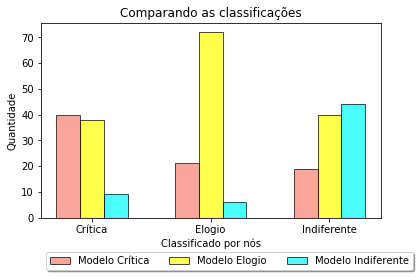

In [30]:
# Agora vamos plotar um gráfico com esses dados!
grupos = 3
indice = np.arange(grupos)

modelo_critica = (40, 21, 19)
modelo_elogio = (38, 72, 40)
modelo_indiferente = (9, 6, 44)
fig, ax = plt.subplots()
bar_larg = 0.2
transp = 0.7
plt.bar(indice, modelo_critica, bar_larg, alpha = transp, edgecolor = 'k', color = "salmon", label = 'Modelo Crítica')
plt.bar(indice + bar_larg, modelo_elogio, bar_larg, alpha = transp, edgecolor ='k', color = "yellow", label = 'Modelo Elogio')
plt.bar(indice + bar_larg + bar_larg, modelo_indiferente, bar_larg, alpha = transp, edgecolor ='k', color = "cyan", label = 'Modelo Indiferente')

plt.xlabel('Classificado por nós') 
plt.ylabel('Quantidade') 
plt.title('Comparando as classificações') 
plt.xticks(indice + bar_larg, ('Crítica', 'Elogio', 'Indiferente')) 
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), shadow=True, ncol=3)
plt.tight_layout() 
plt.show()

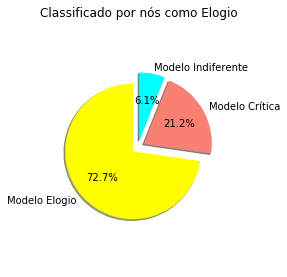

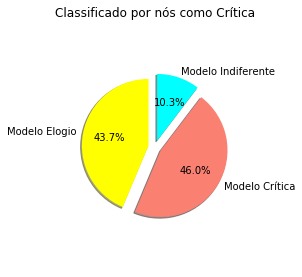

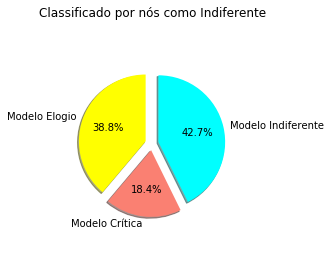

In [31]:
# Agora vamos plotar um gráfico com esses dados!
# Para ter melhor print
from IPython.display import display

plt.figure(figsize=(10, 10))


# Gráfico Classificado por nós como Elogio
labels = ['Modelo Elogio', 'Modelo Crítica', 'Modelo Indiferente']
titulos = [72, 21, 6]
cores = ['yellow', 'salmon', 'cyan']
explode = (0.1, 0.1, 0.1)  # somente explode primeiro pedaço
total = sum(titulos)

plt.subplot(231)
plt.pie(titulos, explode = explode, labels = labels, colors = cores, autopct = '%1.1f%%', shadow = True, startangle=90)
# Determina que as proporções sejam iguais ('equal') de modo a desenhar o círculo
plt.axis('equal') 
plt.title('Classificado por nós como Elogio')
plt.show()

# Gráfico Classificado por nós como Crítica
labels = ['Modelo Elogio', 'Modelo Crítica', 'Modelo Indiferente']
titulos = [38, 40, 9]
cores = ['yellow', 'salmon', 'cyan']
explode = (0.1, 0.1, 0.1)  # somente explode primeiro pedaço
total = sum(titulos)

plt.figure(figsize=(10, 10))
plt.subplot(233)
plt.pie(titulos, explode = explode, labels = labels, colors = cores, autopct = '%1.1f%%', shadow = True, startangle=90)
# Determina que as proporções sejam iguais ('equal') de modo a desenhar o círculo
plt.axis('equal') 
plt.title('Classificado por nós como Crítica')
plt.show()

# Gráfico Classificado por nós como Indiferente
labels = ['Modelo Elogio', 'Modelo Crítica', 'Modelo Indiferente']
titulos = [40, 19, 44]
cores = ['yellow', 'salmon', 'cyan']
explode = (0.1, 0.1, 0.1)  # somente explode primeiro pedaço
total = sum(titulos)

plt.figure(figsize=(10, 10))
plt.subplot(235)
plt.pie(titulos, explode = explode, labels = labels, colors = cores, autopct = '%1.1f%%', shadow = True, startangle=90)
# Determina que as proporções sejam iguais ('equal') de modo a desenhar o círculo
plt.axis('equal') 
plt.title('Classificado por nós como Indiferente')
plt.show()

Dos gráficos acima, é possível inferir que o nosso classificador Naïve-Bayes obteve resultados muito próximos em relação aos tweets classificados como elogio. Isso porque o gráfico indica que os tweets classificados por nós como elogio também foram, majoritariamente, classificados pelo nosso modelo como elogio.

Alguns tweets julgados como crítica foram classificados pelo Naïve-Bayes como sendo elogio. Como o classificador não consegue compreender ironias e classifica o tweet apenas de acordo  com as probabilidades das palavras que o compõe, é possível que alguns tweets sarcáticos tenham sido classificados como elogio, quando, na verdade, eram críticas.

Já nos casos de crítica, o nosso modelo acerta mais que a metade dos tweets, mas comete erros classificando alguns tweets de crítica como elogio. Uma possível causa para isso é que certos tweets de elogio citavam que os produtos da Nike estavam em promoção, e os usuários elogiavam isso. Entretanto, algumas outras vezes apareciam tweets que citavam as promoções, mas continuavam reclamando dos preços altos e esses foram classificados como crítica. No nosso caso, o classificador de Naïve-Bayes não teve a percepção necessária para classificá-los corretamente.

Os tweets que foram julgados por nós como indiferentes eram tweets que não apresentavam opinões criticando ou elogiando a marca. Devido a maneira como o classificador Naïve-Bayes funciona, irá depender somente das probabilidades das palavras daquele tweet específico e pode acontecer que as palavras que o compõem sejam mais comuns em tweets de elogio ou crítica. Por conta dessa dificuldade de percepção do classificador, mais da metade dos tweets julgados indiferente por nós foram classificados incorretamente.

### Sugerindo e explicando melhorias reais com indicações concretas de como implementar

O classificador Naïve-Bayes desconsidera as posições das palavras dentro das frases, calculando apenas as probabilidades individuais de cada palavra. Dessa forma, se ao invés de calcular a probabilidade da palavra sozinha, calcular a probabilidade desse bigrama aparecer, a classificação da frase como um todo poderia se tornar mais eficiente. Isso porque caso apareça as mesmas duas palavras seguidas em diferentes tweets, aproxima a ideia de que esse tweets devem ter a mesma classificação. Ou seja, a probabilidade a ser calculada pelo teorema deve fazer com que os tweets sejam classificadas pelo classificador com a mesma categoria.

_referência:_ https://www.diva-portal.org/smash/get/diva2:839705/FULLTEXT01.pdf

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B) 
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que realiza análise de sentimento e visualiza estes dados

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**